#### RESNET50 Transfer Learning Implementation on the MNIST-HAM10000 Dataset 
- We will utilize the pre-trained ResNet50 CNN Model in order to carry out diagnosis on the image data exclusively.
- The ResNet50 implementation will yield a more accurate model but will be heavy.

In [31]:
#Import Libraries
import tensorflow as tf 
import keras as K 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import os

##### Carry out preliminary data analysis
- Plot distribution of categories in metadata.
- Print metadata information.

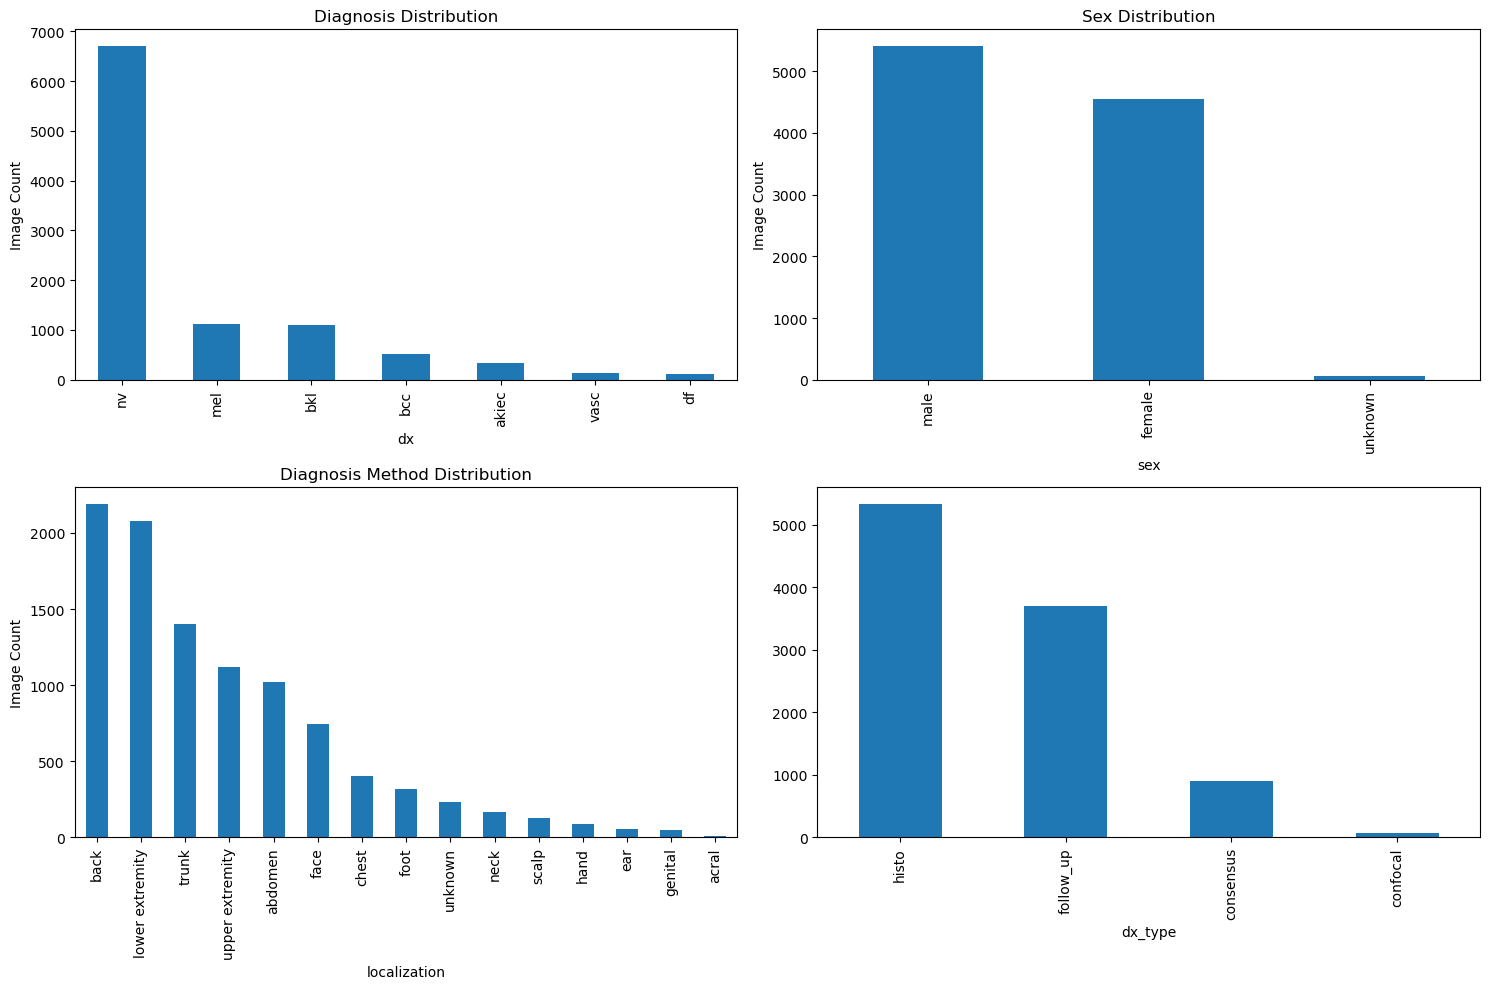

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [14]:
meta_data = pd.read_csv('data/HAM10000_metadata.csv')
fig = plt.figure(figsize=(15, 10))

#Diagnosis Distribution
ax1 = fig.add_subplot(221)
meta_data['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Diagnosis Distribution')
ax1.set_ylabel('Image Count')

#Sex Distribution
ax2 = fig.add_subplot(222)
meta_data['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Sex Distribution')
ax2.set_ylabel('Image Count')

#Localization Distribution 
ax3 = fig.add_subplot(223)
meta_data['localization'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Localization Distribution')
ax3.set_ylabel('Image Count')

#Diagnosis Method Distribution 
ax4 = fig.add_subplot(224)
meta_data['dx_type'].value_counts().plot(kind='bar', ax=ax4)
ax3.set_title('Diagnosis Method Distribution')
ax3.set_ylabel('Image Count')

plt.tight_layout()
plt.show()

#Info
print(meta_data.info())

##### Set up Hyper-Parameters

In [15]:
image_width = 224
image_height = 224
batch_size = 32
test_examples = 5021
validation_examples = 5047
train_examples = 32961

##### Initialize Model
- ResNet50 Pretrained

In [35]:
# #Empty Model
# resnet_model = K.models.Sequential()

# #Pretrained Model
# pretrained_model = K.applications.ResNet50(
#     include_top=False, 
#     input_shape=(224, 224, 3), 
#     pooling='avg', 
#     classes=7,
#     weights='imagenet'
# )

# #Set Pretrained Model weights to untrainable
# # for layer in pretrained_model.layers:
# #     layer.trainable = False

# #Amalgamate our final model
# resnet_model.add(pretrained_model)
# resnet_model.add(K.layers.Flatten())
# resnet_model.add(K.layers.Dense(512, activation='relu'))
# resnet_model.add(K.layers.Dense(196, activation='relu'))
# resnet_model.add(K.layers.Dense(7, activation='softmax'))
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
resnet_model = Model(inputs=base_model.input, outputs=x)

In [36]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [37]:
resnet_model.save('resnet50_19JAN')

INFO:tensorflow:Assets written to: resnet50_19JAN/assets


INFO:tensorflow:Assets written to: resnet50_19JAN/assets


In [41]:
optimizer = Adam(0.0001)
resnet_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

##### Initialize Data Generators and Data Loaders

In [38]:
#Create Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    vertical_flip=True,
)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [39]:
#Instantiate Data Generators into loaders
train_gen = train_datagen.flow_from_directory(
    "data/reorganized_train",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)
test_gen = test_datagen.flow_from_directory(
    "data/reorganized_test",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)
validation_gen = validation_datagen.flow_from_directory(
    "data/reorganized_validation",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

Found 32961 images belonging to 7 classes.
Found 5021 images belonging to 7 classes.
Found 5047 images belonging to 7 classes.


In [40]:
#Load model
resnet_model = K.models.load_model('resnet50_19JAN')

In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('ResNet_Checkpoints',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

##### Train the Model according to Hyper-Parameters.

In [44]:
history = resnet_model.fit(train_gen,
                    epochs=15, 
                    validation_data = validation_gen,
                    callbacks=callback_list)
resnet_model.save('resnet50_19JAN')

Epoch 1/15
1031/1031 [==============================] - ETA: 0s - loss: 3.4604 - accuracy: 0.8112
Epoch 1: val_accuracy improved from -inf to 0.55181, saving model to ResNet_Checkpoints
INFO:tensorflow:Assets written to: ResNet_Checkpoints/assets


INFO:tensorflow:Assets written to: ResNet_Checkpoints/assets


1031/1031 [==============================] - 371s 342ms/step - loss: 3.4604 - accuracy: 0.8112 - val_loss: 3.1616 - val_accuracy: 0.5518 - lr: 1.0000e-04
Epoch 2/15
1031/1031 [==============================] - ETA: 0s - loss: 1.2298 - accuracy: 0.9156
Epoch 2: val_accuracy improved from 0.55181 to 0.58827, saving model to ResNet_Checkpoints
INFO:tensorflow:Assets written to: ResNet_Checkpoints/assets


INFO:tensorflow:Assets written to: ResNet_Checkpoints/assets


1031/1031 [==============================] - 412s 400ms/step - loss: 1.2298 - accuracy: 0.9156 - val_loss: 2.2871 - val_accuracy: 0.5883 - lr: 1.0000e-04
Epoch 3/15
1031/1031 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.9409
Epoch 3: val_accuracy improved from 0.58827 to 0.74440, saving model to ResNet_Checkpoints
INFO:tensorflow:Assets written to: ResNet_Checkpoints/assets


INFO:tensorflow:Assets written to: ResNet_Checkpoints/assets


1031/1031 [==============================] - 308s 299ms/step - loss: 0.5050 - accuracy: 0.9409 - val_loss: 1.2318 - val_accuracy: 0.7444 - lr: 1.0000e-04
Epoch 4/15
1031/1031 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.9501
Epoch 4: val_accuracy did not improve from 0.74440
1031/1031 [==============================] - 304s 294ms/step - loss: 0.2716 - accuracy: 0.9501 - val_loss: 1.1799 - val_accuracy: 0.7315 - lr: 1.0000e-04
Epoch 5/15
1031/1031 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.9571
Epoch 5: val_accuracy did not improve from 0.74440

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1031/1031 [==============================] - 355s 345ms/step - loss: 0.1873 - accuracy: 0.9571 - val_loss: 1.1827 - val_accuracy: 0.7107 - lr: 1.0000e-04
Epoch 6/15
1031/1031 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9797
Epoch 6: val_accuracy improved from 0.74440 to 0.76957, saving mo

INFO:tensorflow:Assets written to: ResNet_Checkpoints/assets


1031/1031 [==============================] - 263s 255ms/step - loss: 0.0982 - accuracy: 0.9797 - val_loss: 1.0016 - val_accuracy: 0.7696 - lr: 5.0000e-05
Epoch 7/15
1031/1031 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9823
Epoch 7: val_accuracy did not improve from 0.76957
1031/1031 [==============================] - 348s 337ms/step - loss: 0.0776 - accuracy: 0.9823 - val_loss: 1.3452 - val_accuracy: 0.6832 - lr: 5.0000e-05
Epoch 8/15
1031/1031 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9844
Epoch 8: val_accuracy did not improve from 0.76957

Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1031/1031 [==============================] - 260s 252ms/step - loss: 0.0691 - accuracy: 0.9844 - val_loss: 1.8364 - val_accuracy: 0.6766 - lr: 5.0000e-05
Epoch 9/15
1031/1031 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9912
Epoch 9: val_accuracy did not improve from 0.76957
1031/1031 [===

INFO:tensorflow:Assets written to: resnet50_19JAN/assets


In [45]:
resnet_model.evaluate(validation_gen)
resnet_model.evaluate(test_gen)

157/157 [==============================] - 16s 100ms/step - loss: 1.3516 - accuracy: 0.7574


[1.351599931716919, 0.7574188113212585]

In [46]:
resnet_model.save("Prototyped_Models/resnet-50_standard.h5", save_format='h5')

/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Convert to tflite

In [47]:
converter = tf.lite.TFLiteConverter.from_keras_model(resnet_model)
tflite_model = converter.convert()
open("Prototyped_Models/converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0joz_9zr/assets


INFO:tensorflow:Assets written to: /tmp/tmp0joz_9zr/assets
2024-01-20 00:46:11.757694: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-20 00:46:11.757725: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-20 00:46:11.757884: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0joz_9zr
2024-01-20 00:46:11.780425: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-20 00:46:11.780454: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp0joz_9zr
2024-01-20 00:46:11.848559: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-20 00:46:12.754358: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp0joz_9zr
2024-01-20 00:46:12.978972: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

96075236

[1. 0. 0. 0. 0. 0. 0.]


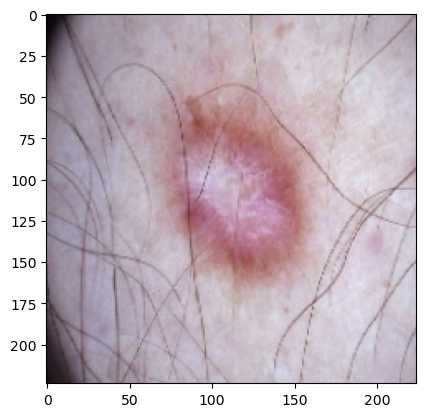

In [75]:
image = train_gen.next()[0][0]
plt.imshow(image)
print(train_gen.next()[1][0])

In [76]:
prediction = tf.round(resnet_model(image.reshape(1, 224, 224, 3)))
print(prediction)

tf.Tensor([[0. 0. 0. 1. 0. 0. 0.]], shape=(1, 7), dtype=float32)
